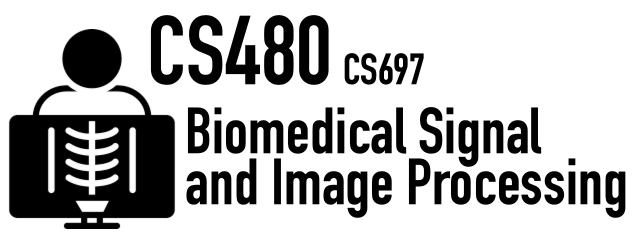
#Assignment 4

In [ ]:
# Creating a Random Forest classifier to detect pneumonia!

In [1]:
# load numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# we are using mahotas again.
!pip install mahotas
!pip install Pillow

In [3]:
# our imports include sklearn this time
import mahotas as mh
import os
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Task 1:** Download, extract, and load the data!

In [4]:
# Please download this file: https://cs480.org/data/xray.zip
# This is a subset of the Kaggle Pneumonia Dataset!
#
# Upload xray.zip using the file panel on the left.

# AUTO DOWNLOAD WITH CURL
!curl https://cs480.org/data/xray.zip --output xray.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 61.4M    0  1371    0     0   1371      0 13:03:26  0:00:01 13:03:25   790
 33 61.4M   33 20.2M    0     0  10.1M      0  0:00:06  0:00:02  0:00:04 7779k
 74 61.4M   74 45.8M    0     0  15.2M      0  0:00:04  0:00:03  0:00:01 12.4M
100 61.4M  100 61.4M    0     0  15.3M      0  0:00:04  0:00:04 --:--:-- 14.7M


In [5]:
# Run this code to extract the zip file and to create
# the folder structure of normal/ and pneumonia/ images.
# Each folder contains the first images of the Kaggle dataset.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'

In [6]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg', as_grey=True)

Dimension: (1858, 2090)


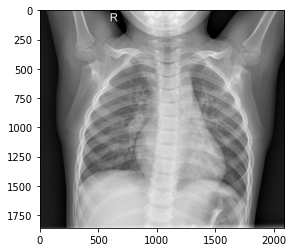

In [8]:
# display this image and print the dimensions!
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
print(f"Dimension: {img.shape}")

**Task 2:** Let's do some data wrangling and more visualization!

In [ ]:
# The two code blocks above perform 2 data wrangling operations.
# Which ones?
# Hint: The first one might be more obvious but the second one happens in the
# last line of each block.
# Operation 1) The first operation is collecting the normal images,
# Operation 2) The second operation is collecting the pneumonia images, 

In [10]:
# This code loads all normal images into a numpy array.
normal_files = os.listdir( NORMAL_DIR )
normal_images = np.zeros( (len(normal_files), 300, 300), dtype=np.float32)

for i in range(len(normal_files)):
  loaded_image = mh.imread( NORMAL_DIR + normal_files[i], as_grey=True )

  loaded_image = mh.imresize( loaded_image, (300, 300) )
  img_shape = loaded_image.shape

  normal_images[ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

# print(normal_images[:2])

In [11]:
# This code loads all pneumonia images into a numpy array.
pneumonia_files = os.listdir( PNEUMONIA_DIR )
pneumonia_images = np.zeros( (len(pneumonia_files), 300, 300), dtype=np.float32)

for i in range(len(pneumonia_files)):
  loaded_image = mh.imread( PNEUMONIA_DIR + pneumonia_files[i], as_grey=True )
  
  loaded_image = mh.imresize( loaded_image, (300, 300) )
  img_shape = loaded_image.shape

  pneumonia_images[ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [ ]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

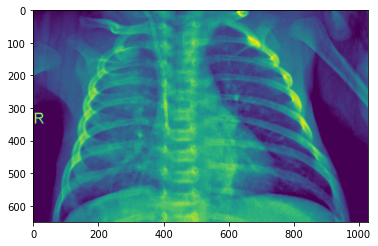

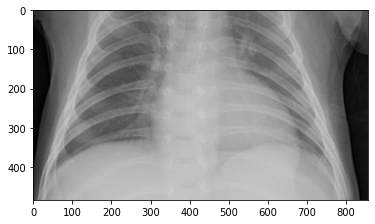

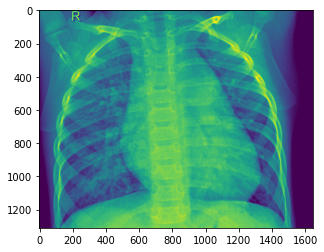

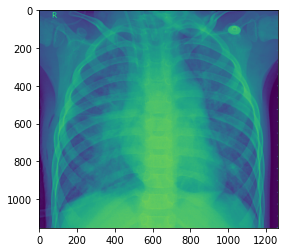

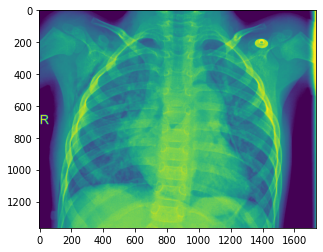

In [12]:
# Visualizing multiple images at once.
def visualizePneumonia(filename: str=None) -> None:
    # View multiple images stored in files, stacking vertically
    # Arguments: str - path to filename containing image
    pics = mpimg.imread(filename)
    # <something gets done here>
    plt.figure()
    plt.imshow(pics)
for file in pneumonia_files[:5]:
    file_imagings = PNEUMONIA_DIR + file
    visualizePneumonia(file_imagings)

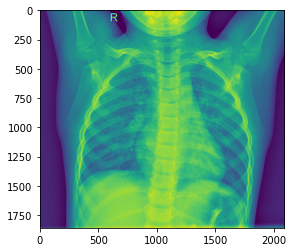

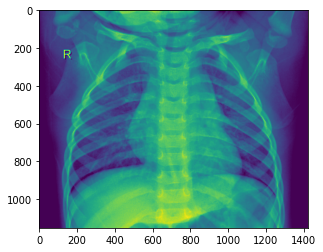

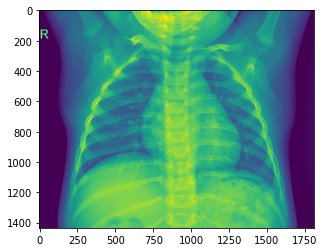

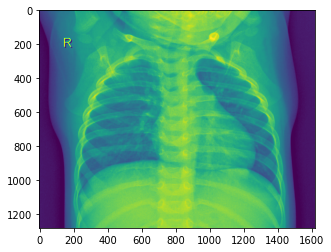

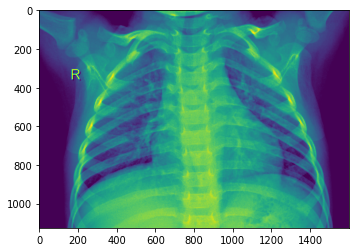

In [13]:
def visualizeNormal(filename: str=None) -> None:
    # View multiple images stored in files, stacking vertically
    # Arguments: str - path to filename containing image
    pics = mpimg.imread(filename)
    # <something gets done here>
    plt.figure()
    plt.imshow(pics)
for file in normal_files[:5]:
    file_imagings = NORMAL_DIR + file
    visualizeNormal(file_imagings)

In [14]:
def show_images(images, num_of_images=5):
    fig, ax = plt.subplots(1, num_of_images, figsize=[25,25])
    for i in range(num_of_images):
        ax[i].set_title('Image %d' %i)
        ax[i].imshow(images[i], cmap='gray')
        ax[i].axis('off')
    plt.show()


First 5 normal images


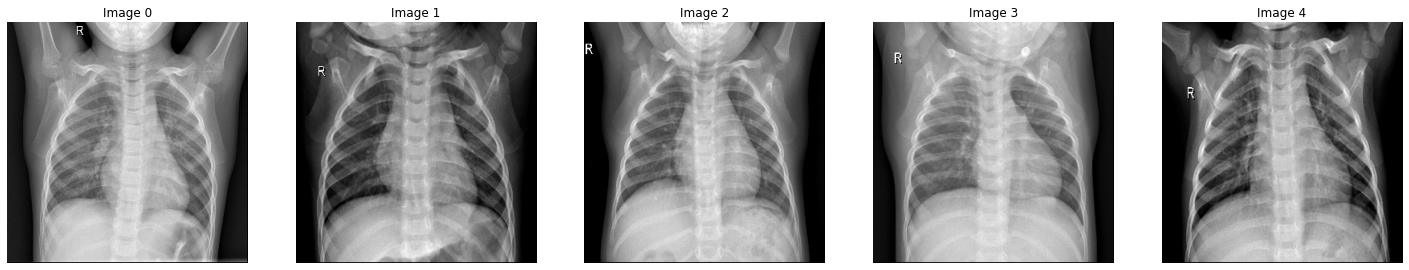

In [15]:
print("First 5 normal images")
show_images(normal_images)

First 5 pneumonia images


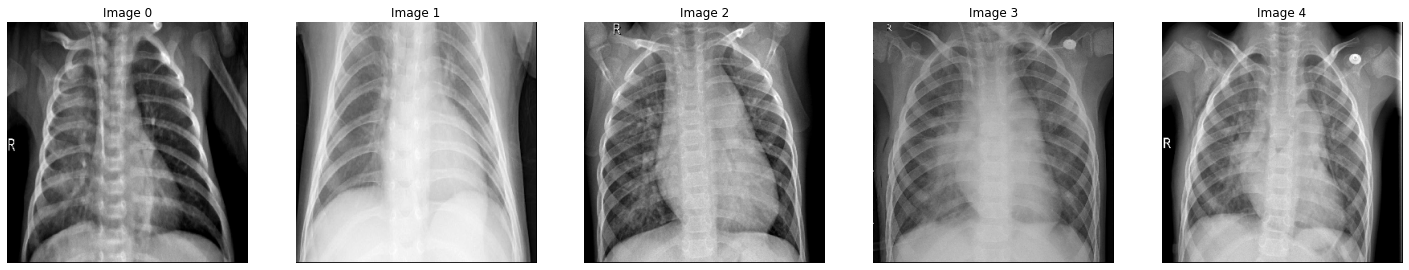

In [16]:
print("First 5 pneumonia images")
show_images(pneumonia_images)

**Task 3:** Setup training and testing data.

In [ ]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays and pneumonia xrays.
#
# The training data will include 120 images (60 normal, 60 pneumonia).
# The testing data will include the remaining 80 images (40 normal, 40 pneumonia).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the training_target vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia.

In [17]:
TRAINING_COUNT = 60

training_data = np.zeros( (TRAINING_COUNT * 2, 300*300 ), dtype=np.float32)
for i, n in enumerate( normal_images[0:TRAINING_COUNT] ):
  training_data[i] = n.ravel() # flatten the image
for i, p in enumerate( pneumonia_images[0:TRAINING_COUNT] ):
  training_data[i + TRAINING_COUNT] = p.ravel()

In [18]:
# creating the training_target vector with
# 0 for a normal image, and
# 1 for a pneumonia.
training_target = []
for count in range(TRAINING_COUNT):
    count = 0
    training_target += [count]
for count in range(TRAINING_COUNT):
    count = 1
    training_target += [count]

print(training_target)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [19]:
TESTING_COUNT = 40

testing_data = np.zeros( (TESTING_COUNT * 2, 300*300 ), dtype=np.float32)
for i, n in enumerate( normal_images[TRAINING_COUNT:TRAINING_COUNT+TESTING_COUNT] ):
  testing_data[i] = n.ravel() # flatten the image
for i, p in enumerate( pneumonia_images[TRAINING_COUNT:TRAINING_COUNT+TESTING_COUNT] ):
  testing_data[i + TESTING_COUNT] = p.ravel()

In [20]:
# TODO: Please create the testing_target vector 
# with 0 for a normal image, and
# 1 for a pneumonia.
testing_target = []

for count in range(TESTING_COUNT):
    count = 0
    testing_target += [count]
for count in range(TESTING_COUNT):
    count = 1
    testing_target += [count]

print(testing_target)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


**Task 4:** Let's train and evaluate the Random Forest!

In [21]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [22]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is 
# normal or pneumonia.
fitted = clf.fit( training_data, training_target )

Decision Trees are also the fundamental components of Random Forests, which are among the most powerful Machine Learning algorithms. Random Forest classifiers can directly classify instances into multiple classes and can limit this instability by averaging predictions over many trees. The Random Forest algorithm introduces extra randomness when growing trees instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features.


In [23]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
print(f"Classification accuracy: {np.mean(clf.score( testing_data, testing_target )) *100:.2f}%")

Classification accuracy: 92.50%


**Is the classification accuracy good? And, are you surprised**

* I believe the approximation (92.5%) is the good one.
* The result is pretty good, with 92.5% accuracy. I am supprised because
looking at the images printed out back in Task 2, the normal images are all
pretty similar to each other, while the pneumonic lungs are much more 
irregular and often have much less empty space in the lungs/ribs.
* Before I did that I was quite surprised. I was more surprised at how quickly the
model was trained and able to classify with such accuracy.

**Bonus:** Let's take a closer look! [33 Points]

In [ ]:
# Can you figure out which images were misclassified?
# Can you display them?
# Do you have an idea why these images were problematic?

In [24]:
# To evaluate the model, need to make prediction first.
predictions = clf.predict(testing_data)
print("Expected prediction: ", testing_target)
print("Actual prediction: ", predictions)
wrong_predictions = np.where(testing_target != predictions)[0]
print("Wrong classifications: ", wrong_predictions)


Expected prediction:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Actual prediction:  [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1]
Wrong classifications:  [ 7  9 46 59 64 75]


In [25]:
# In the wrong classifications, indices smaller than 40 (testing count for each type) is from normal images. The remaining is from pneumonia images
# We need to calculate their indices from the original data set
normal_images_indices = wrong_predictions[wrong_predictions < 40]
pneumonia_images_indices = wrong_predictions[wrong_predictions >= 40]

# Then, we need to get their according indices in the original data set
normal_images_indices = normal_images_indices + TRAINING_COUNT
pneumonia_images_indices = pneumonia_images_indices - TESTING_COUNT + TRAINING_COUNT

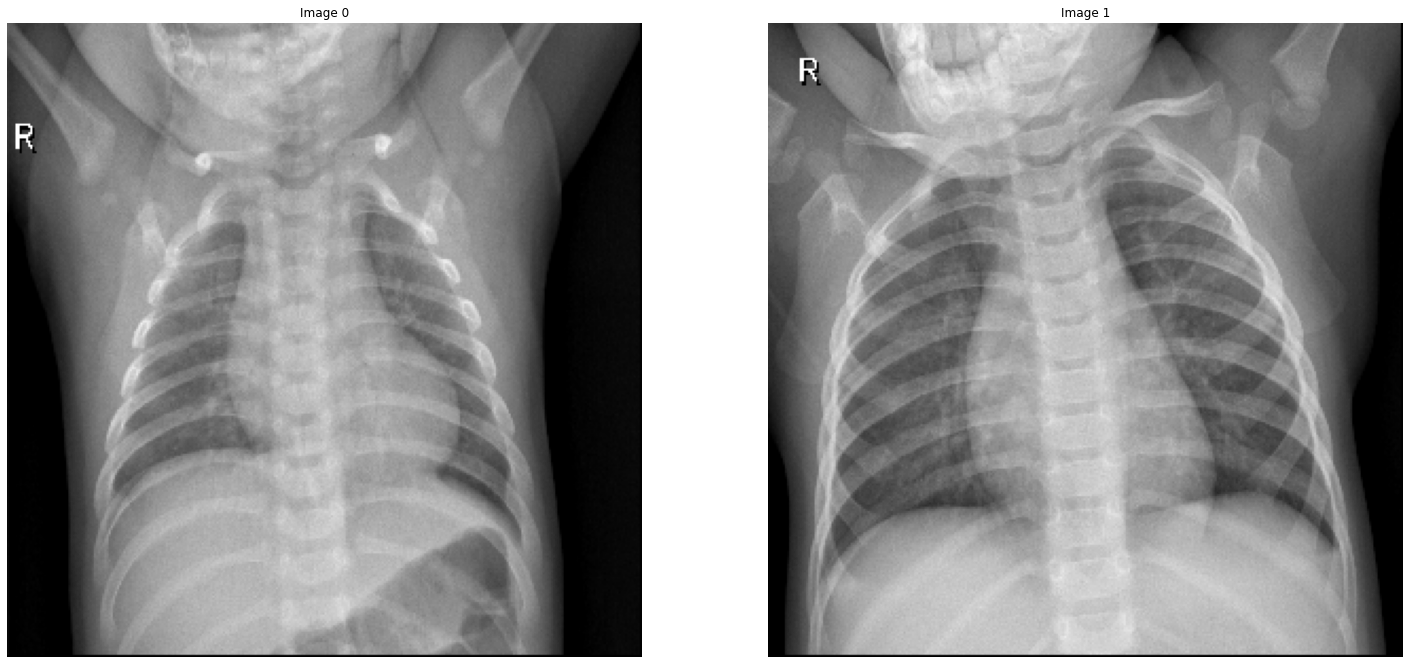

In [26]:
# Show the wrong predicted images 
show_images(normal_images[normal_images_indices], num_of_images= len(normal_images_indices))

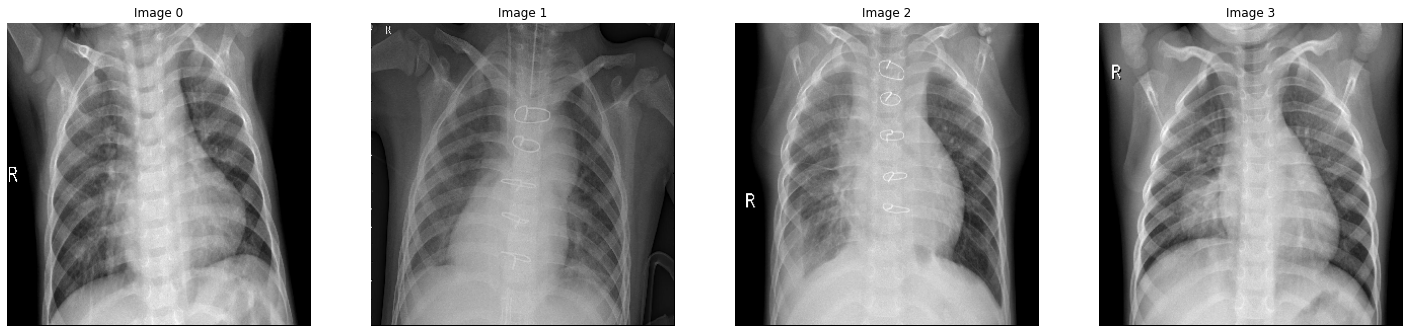

In [27]:
show_images(pneumonia_images[pneumonia_images_indices], len(pneumonia_images_indices))

**How can we improve the classification performance?**

Some methods to improve the classification performance:
1) try different amount of n_estimators
2) Tuning the hyperameter or random forest to using the KNN in the Scikit library
3) Feature importance
4) Matrix confusion

In [28]:
my_clf = RandomForestClassifier(n_estimators=200)
my_fitted = my_clf.fit(training_data, training_target)
print("New accuracy: ", my_clf.score(testing_data, testing_target))

New accuracy:  0.9375


In [ ]:
           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw